In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict

import matplotlib.pylab as plt
import seaborn as sns

import datetime
import random
from tqdm import tqdm
import itertools

import networkx as nx
import queue

import functions as fn

from collections import deque
from treelib import Node, Tree

## Data

In [2]:
df = pd.read_csv('wikigraph_reduced.csv')

In [3]:
df = df['\t0\t1'].str.split('\t', n=2, expand = True)
df.rename(columns={0: "edge",1: "source", 2: "target"}, inplace = True)
df.head(10)

,edge,source,target
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222
5,1143,134,1061485
6,1146,134,1163610
7,1147,134,1163783
8,1309,153,744272
9,1311,153,1064807


In [4]:
weight = [1]*len(df)
df['weight'] = weight
df.head()

,edge,source,target,weight
0,796,95,1185516,1
1,909,108,1059989,1
2,910,108,1062426,1
3,911,108,1161925,1
4,1141,134,541222,1


In [5]:
pages = pd.read_csv('wiki-topcats-page-names.txt', header = None, names = ['page'])
pages = pages['page'].str.split(' ', n=1, expand = True)
pages.drop(0,axis=1, inplace = True)
pages.rename(columns={1:'pageName'},inplace=True)

In [6]:
pages.head()

,pageName
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem


In [7]:
file = open("wiki-topcats-categories.txt", "r")
contents = file.read()
contents = contents.split("\n")
file.close()

## Initial Anlysis

In [8]:
#dictionary that has for keys the category and for value the list of pages in that category
dictionary_cat = {}

for i in tqdm(range(len(contents))):
    
    temp = contents[i].split(";")    
    if len(temp)>1:
    
        key = temp[0]
        key = key[9::]
        key

        list_page_frcat = temp[1].split(" ")
        list_page_frcat = list_page_frcat[1::]
        list_page_frcat

        dictionary_cat[key] = list_page_frcat

100%|██████████| 17365/17365 [00:00<00:00, 29721.81it/s]


In [9]:
len(dictionary_cat)

17364

From this dictionary we need to remove first the categories that have less than 5000 and more than 30000 pages associated

In [10]:
categories_to_drop = []
for key, value in dictionary_cat.items():
    if len(value)<5000 or len(value)>30000:
        categories_to_drop.append(key)

In [11]:
len(categories_to_drop)

17343

In [12]:
#create a new dictionary by including only the categories that are not in the list categories_to_drop
dictionary_cat = {i:dictionary_cat[i] for i in dictionary_cat if i not in categories_to_drop}

In [13]:
len(dictionary_cat)

21

In [14]:
dictionary_cat.keys()

dict_keys(['English_footballers', 'The_Football_League_players', 'Association_football_forwards', 'Association_football_midfielders', 'Association_football_defenders', 'Harvard_University_alumni', 'Major_League_Baseball_pitchers', 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies', 'Indian_films', 'Year_of_death_missing', 'Rivers_of_Romania', 'Main_Belt_asteroids', 'Asteroids_named_for_people', 'English-language_films', 'American_films', 'American_television_actors', 'American_film_actors', 'Debut_albums', 'Black-and-white_films', 'Year_of_birth_missing', 'Place_of_birth_missing_(living_people)'])

In [15]:
for key,value in dictionary_cat.items():
    print(f'{key}: {len(value)}')

English_footballers: 9237
The_Football_League_players: 9467
Association_football_forwards: 6959
Association_football_midfielders: 8270
Association_football_defenders: 6668
Harvard_University_alumni: 6154
Major_League_Baseball_pitchers: 6580
Members_of_the_United_Kingdom_Parliament_for_English_constituencies: 6546
Indian_films: 5913
Year_of_death_missing: 7851
Rivers_of_Romania: 7729
Main_Belt_asteroids: 13704
Asteroids_named_for_people: 5701
English-language_films: 22699
American_films: 15302
American_television_actors: 11661
American_film_actors: 13938
Debut_albums: 8401
Black-and-white_films: 12174
Year_of_birth_missing: 7237
Place_of_birth_missing_(living_people): 6767


In [16]:
#dictionary that associates to each page, the list of categories that is in
inverted_link = {}

for key,value in tqdm(dictionary_cat.items()):
    if value != None:

        for elem in value: 
            if elem not in inverted_link.keys():             
                inverted_link[elem] = []
                inverted_link[elem].append(key)

            else:
                inverted_link[elem].append(key)

100%|██████████| 21/21 [00:00<00:00, 194.48it/s]


In [17]:
#list that has all the pages that have are associated to more than 1 category
key_list = []
for key in inverted_link.keys():
    if len(inverted_link[key])>1:
        key_list.append(key)
print(f'number of pages that appear in more than one category: {len(key_list)}')

number of pages that appear in more than one category: 41555


In [18]:
inverted_link["22860"]

['English_footballers', 'Association_football_defenders']

In [19]:
#dictionary that shows the distribution of the pages in each category
len_list = {}

for key in key_list:     
    lenght = len(inverted_link[key]) 
    
    if lenght not in len_list.keys():             
                len_list[lenght] = 1
    else:
        len_list[lenght] += 1

In [20]:
len_list

{2: 34371, 3: 6783, 4: 378, 5: 22, 6: 1}

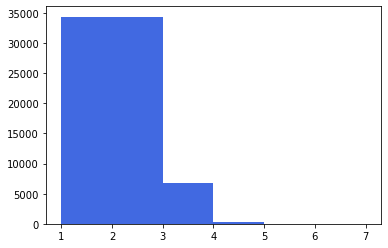

In [21]:
plt.bar(len_list.keys(), len_list.values(), width = 2.0, color='royalblue')
plt.xlim = (0, max(len_list.keys()))

For every page in the inverted index (key) I uniformly choose at random the category in which belongs and I create a new dictionary where the categories are the keys and the pages in each category are the values.

In [22]:
#final dictionary where the pages that appear in multiple categories are assigned to only one uniformly at random
final_category_dict = dict.fromkeys(dictionary_cat.keys())

for key,value in tqdm(inverted_link.items()):
    category = str(*np.random.choice(value, size=1, replace=False, p= None))
    if final_category_dict[category] == None:
        final_category_dict[category] = [key]
    else:
        final_category_dict[category].append(key)    

100%|██████████| 149794/149794 [00:02<00:00, 51126.59it/s]


#### Trial to see if the above operation worked

In [23]:
#dictionary that associates to each page, the list of categories that it is in
inverted_link2 = {}

for key,value in tqdm(final_category_dict.items()):
    if value != None:

        for elem in value: 
            if elem not in inverted_link2.keys():             
                inverted_link2[elem] = []
                inverted_link2[elem].append(key)

            else:
                inverted_link2[elem].append(key)

100%|██████████| 21/21 [00:00<00:00, 47.87it/s]


In [24]:
key_list = []
for key in inverted_link2.keys():
    if len(inverted_link2[key])>1:
        key_list.append(key)
key_list

[]

This proves that now there are no pages that appear in multiple categories

# Creating the graph 

In [25]:
# create the graph
G = nx.from_pandas_edgelist(df, "source", "target",create_using=nx.MultiDiGraph(), edge_attr = 'weight')

*Is this the correct graph?* 

We can visualize all the edges of the graph by the command `G.edges()`, however since this will generate a long list we just check some examples.

In [26]:
df.iloc[900]

edge      688634
source     41914
target    633362
weight         1
Name: 900, dtype: object

In [27]:
G['41914']

AdjacencyView({'633362': {0: {'weight': 1}}})

In [28]:
print(df.iloc[1456],'\n')
print(df.iloc[1457])

edge      1193155
source      65522
target      35186
weight          1
Name: 1456, dtype: object 

edge      1193161
source      65522
target      64932
weight          1
Name: 1457, dtype: object


In [29]:
G['65522'] # this node has multiple target values 

AdjacencyView({'35186': {0: {'weight': 1}}, '64932': {0: {'weight': 1}}, '65074': {0: {'weight': 1}}})

# Answering the questions

**Is the graph directed?**

Yes, since the edges that compose the graph are ordered pairs of the form $(a,b)$. These pairs represent a hyperlink *from* the article $a$ *to* the article $b$. 

<font color='red'>find example of couple doesn't have reverse</font>

**How many articles are we considering?**

Every node in the graph represents a wikipedia article. Therefore: 

In [30]:
len(G) # this returns the number of nodes in the graph 

98343

**How many hyperlinks between pages exist?**

Every edge in the graph represents a hyperlink between articles. Therefore:

In [31]:
G.number_of_edges() # this returns the number of edges in the graph 

483094

*Notice that in counting hyperlinks the order of the pairs is important: $(a,b)$ and $(b,a)$ will count as $2$ hyperlinks.*

**Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?**

For the first part of the question, the answer is given by the formula: $\frac{|E|}{|V|}$ 
(where $|E|$ is the number of edges and $|V|$ is the number of vertices)

In [32]:
G.number_of_edges() / len(G)

4.912337431235573

For the second part of the question is important to understand what we mean by *graph density*. 

We will define *graph density* as the ratio between the number of edges and the maximum number of possible edges. In order to calculate what is the maximum number of edges of a graph, we need to understand what type of graph we are dealing with. 
`G` is a directed multigraph, therefore the set of all edges is $U := \{(x,y) \, \,  | \, \, (x,y) \in V^2: x \neq y\}$, therefore: $|U| = |V| \cdot |V-1|$ .

The density of the graph `G` is:

In [33]:
G.number_of_edges() / ( len(G)*(len(G)-1) )

4.9951571365597335e-05

<font color='red'>This might be parse?</font>

**Visualize the nodes' degree distribution**

In [34]:
# p_k histograms 

### Some final cleaning
We need to clean one last time the categories file: we should consider only the nodes given in the reduced version of the graph. Therefore we are checking and removing the other ones and based on that.

In [35]:
nodes_to_consider=set(G.nodes())
len(nodes_to_consider)

98343

In [36]:
len(final_category_dict['English_footballers'])

5046

In [37]:
categories_to_drop = []
for key, value in final_category_dict.items():
    final_category_dict[key] = [values for values in value if values in nodes_to_consider]
    if len(final_category_dict[key])<5000:
        categories_to_drop.append(key)

In [38]:
len([values for values in final_category_dict['English_footballers'] if values in nodes_to_consider])

3611

In [39]:
for key,value in final_category_dict.items():
    print(f'{key}: {len(value)}')

English_footballers: 3611
The_Football_League_players: 3628
Association_football_forwards: 2512
Association_football_midfielders: 2791
Association_football_defenders: 2112
Harvard_University_alumni: 2972
Major_League_Baseball_pitchers: 3308
Members_of_the_United_Kingdom_Parliament_for_English_constituencies: 6424
Indian_films: 2744
Year_of_death_missing: 1385
Rivers_of_Romania: 7662
Main_Belt_asteroids: 8702
Asteroids_named_for_people: 2296
English-language_films: 13322
American_films: 7489
American_television_actors: 6443
American_film_actors: 9118
Debut_albums: 2553
Black-and-white_films: 5256
Year_of_birth_missing: 1477
Place_of_birth_missing_(living_people): 2538


### RQ2. Function 1

#### Define a function that takes in input:

- A page *v*
- A number of clicks *d*

#### and returns the set of all pages that a user can reach within *d* clicks.

#### AGGIUNGEREI UNA SPIEGAZIONE BREVE DI COME ABBIAMO INTERPRETATO LA TRACCIA E QUINDI SVILUPPATO L'ALGORITMO

Here some examples of the application: 

In [40]:
Q = fn.rq2(G,'65522', 2)    

In [41]:
Q.show()

65522
├── 35186
│   ├── 1089422
│   ├── 1089520
│   ├── 1159720
│   ├── 1262005
│   ├── 1400478
│   ├── 1403584
│   ├── 245134
│   ├── 35170
│   ├── 35191
│   ├── 35192
│   └── 540950
├── 64932
│   ├── 1762988
│   ├── 457596
│   ├── 64878
│   ├── 65004
│   ├── 65009
│   ├── 65034
│   ├── 65110
│   ├── 65142
│   ├── 65299
│   ├── 65596
│   └── 65806
└── 65074



### RQ3. Function 2

#### Define a function that takes in input:

- A category *C*
- A set of pages in *C*, *p = {p1, ..., pn}*

#### and returns the minimum number of clicks required to reach all pages in *p*, starting from the page *v*, corresponding to the most central article, according to the *in-degree* centrality, in *C*.

---
Our interpretation of the problem consists of finding the maximum number of clicks needed to get from the selected central page v, to the furthest page away in terms of clicks. To solve this problem we worked with the neighbors of each page in the graph.

We developed two different methods to do so:
1. consider only the node neighbors that are inside the category in input
2. consider all the neighbors since even the pages not inside the categories could be used to create a path starting from v

For both methods we first defined a measure of centarlity based on the in-degree of each node: the number with the most number of incoming links among all the nodes in the category will be selected as the staring point of our algorithm.

### 1. Neighbors are only the pages inside the same catgory in input

Starting from page $v$ we will detect its neighbors in the graph, but we will select only those who belong to the same category of $v$. This pages are all the ones that can be reached in $1$ click from $v$.

In the second interation we looked at the neighbors of all the pages stores in interation $1$, and we will store in a list the pages that are inside the same category of $v$ *AND* weren't found in the previous iterations. Those are the pages that can be reached in $2$ clicks.

We repeat this process in a recursive way until no more neighbors that obey to our conditions are found. At this point we will check if the total number of pages of the category reached by our function is equal to the effective number of pages in the category in input. In this case the function would return the number of iteration where it stopped, that is exactly the minimun number of clicks needed to reacha all pages $p$, starting from page $v$. If, on the other hand, the total was smaller, the function would just return **NOT POSSIBLE** because it didn't find any path to get from page $v$ to all the pages of the category.


---
*N.B.* Since our implementation that founds the most central node takes some time, for this initial trial we used the built in function that computes it in very small time. Later on, to try the actual algorithm selecting a category in input, we will recall our actual function

---

In [42]:
for category in final_category_dict.keys():
    print(category)
    init_set_pages = final_category_dict[category]
    
    subG = G.subgraph(init_set_pages)
    in_degrees = nx.in_degree_centrality(subG)

    m = max(in_degrees.values())
    for key, value in in_degrees.items():
        if value == m:
            v = key

    print(fn.min_clicks(G, df, pages, final_category_dict,v,category, init_set_pages))
    print('\n')

English_footballers
Iteration 0. Pages reached in 0 click: 18
Iteration 1. Pages reached in 1 click: 86
Iteration 2. Pages reached in 2 click: 243
Iteration 3. Pages reached in 3 click: 216
Iteration 4. Pages reached in 4 click: 150
Iteration 5. Pages reached in 5 click: 87
Iteration 6. Pages reached in 6 click: 53
Iteration 7. Pages reached in 7 click: 34
Iteration 8. Pages reached in 8 click: 23
Iteration 9. Pages reached in 9 click: 19
Iteration 10. Pages reached in 10 click: 10
Iteration 11. Pages reached in 11 click: 3
Iteration 12. Pages reached in 12 click: 0
(12, 'Not Possible, total pages reached: 942 out of 3611')


The_Football_League_players
Iteration 0. Pages reached in 0 click: 21
Iteration 1. Pages reached in 1 click: 88
Iteration 2. Pages reached in 2 click: 187
Iteration 3. Pages reached in 3 click: 224
Iteration 4. Pages reached in 4 click: 206
Iteration 5. Pages reached in 5 click: 130
Iteration 6. Pages reached in 6 click: 99
Iteration 7. Pages reached in 7 click: 5

Iteration 13. Pages reached in 13 click: 14
Iteration 14. Pages reached in 14 click: 17
Iteration 15. Pages reached in 15 click: 15
Iteration 16. Pages reached in 16 click: 15
Iteration 17. Pages reached in 17 click: 13
Iteration 18. Pages reached in 18 click: 14
Iteration 19. Pages reached in 19 click: 11
Iteration 20. Pages reached in 20 click: 11
Iteration 21. Pages reached in 21 click: 4
Iteration 22. Pages reached in 22 click: 4
Iteration 23. Pages reached in 23 click: 5
Iteration 24. Pages reached in 24 click: 2
Iteration 25. Pages reached in 25 click: 3
Iteration 26. Pages reached in 26 click: 0
(26, 'Not Possible, total pages reached: 259 out of 7489')


American_television_actors
Iteration 0. Pages reached in 0 click: 33
Iteration 1. Pages reached in 1 click: 102
Iteration 2. Pages reached in 2 click: 287
Iteration 3. Pages reached in 3 click: 462
Iteration 4. Pages reached in 4 click: 452
Iteration 5. Pages reached in 5 click: 275
Iteration 6. Pages reached in 6 click: 127
It

We tried to implement our method iterating in all the categories, and, as we can see above, there is not even one case where the algorithm finds that all the nodes are connected.

To answer the question we will let the user choose in input the category, but also a list of pages in that category:

In [57]:
category = input('choose a category: ')

#this input has to be written in the format: ['page1','page2',...,'pageN'] where each page is a number
#pages_in_category = input('choose a list of pages in the category: ')

#to make it easier we will generate this list random, but if you want to test it you can just uncomment the line above
init_set_pages = random.sample(final_category_dict[category], 200)

v = fn.most_central_article(df, pages, final_category_dict, category,init_set_pages)
print(f'The starting node is: {v}')

choose a category: Rivers_of_Romania
The starting node is: 786513


In [58]:
print(fn.min_clicks(G, df, pages, final_category_dict,v,category, init_set_pages))

Iteration 0. Pages reached in 0 click: 1
Iteration 1. Pages reached in 1 click: 1
Iteration 2. Pages reached in 2 click: 0
(2, 'Not Possible, total pages reached: 2 out of 200')


### 2. All the neighbors are considered

Starting from page $v$ our idea was to look at all the neighbors of $v$ in the directed graph. From the list of neighbors generated we distinguished from the pages that belonged to the category in input and those who didn't. The first ones were all the pages that could be reached in $1$ click from $v$, the second ones were stored because they could create a path to reach other pages in the category.

In the second iteration we looked at the neighbors of all the pages found in iteration 1. Again we divided the pages into those who belonged to the category (that are now all the pages that can be reached in 2 clicks starting from v), and those who didn't.

We repeated the process in a recursive way until the function returned an empty list of pages inside the category reached in that iteration. At this point, if the total number of pages of the category reached by our function was equal to the effective number of pages in the category, the function would return the number of iteration where it stopped, that is exactly the minimun number of clicks needed to reacha all pages $p$, starting from page $v$. If, on the other hand, the total was smaller, the function would just return **NOT POSSIBLE** because it didn't find any path to get from page $v$ to all the pages of the category

In [54]:
category = input('choose a category: ')
#this input has to be written in the format: ['page1','page2',...,'pageN'] where each page is a number
#pages_in_category = input('choose a list of pages in the category: ')

#to make it easier we will generate this list random, but if you want to test it you can just uncomment the line above
init_set_pages = random.sample(final_category_dict[category], 500)

v = fn.most_central_article(df, pages, final_category_dict, category, init_set_pages)
print(f'The starting node is: {v}')

choose a category: Rivers_of_Romania
The starting node is: 785970


In [55]:
print(fn.min_clicks2(G, df, pages, final_category_dict,v,category,init_set_pages))

Iteration 0. Pages reached in 1 click: 4
Iteration 1. Pages reached in 2 click: 9
Iteration 2. Pages reached in 3 click: 39
Iteration 3. Pages reached in 4 click: 112
Iteration 4. Pages reached in 5 click: 151
Iteration 5. Pages reached in 6 click: 76
Iteration 6. Pages reached in 7 click: 32
Iteration 7. Pages reached in 8 click: 4
Iteration 8. Pages reached in 9 click: 1
Iteration 9. Pages reached in 10 click: 1
Iteration 10. Pages reached in 11 click: 0
(10, 'Not Possible, total pages reached: 429 out of 500')


### RQ4. Induced Subgraph

#### Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.
 - Let *v* and *u* two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect *u* and *v*?

In [452]:
# the example is made with 'English_footballers' and 'The_Football_League_players'

category1 = input('choose a first category: ')
category2 = input('choose a second category: ')

set_pages = final_category_dict[category1]  + final_category_dict[category2] 
mod_df = df

In [453]:
G = nx.from_pandas_edgelist(mod_df, "source", "target",create_using=nx.MultiDiGraph())
#we take a subgraph of G containing just nodes in set_pages
H = nx.subgraph(G, set_pages )

In [462]:
#counter is number of hyperlink: it is initialized in main
counter = 0
#nodes are chosen randomly from the subgraph
nodes = np.random.choice(set_pages, size=2, replace=False, p= None)
u,v = nodes[0], nodes[1]
fn.hyper_remove(H, mod_df, set_pages, final_category_dict , category1 , category2, u, v, counter)

Path #1: Shortest distance 9


(1, 'Number of minimum hyperlink removed to disconnect 78448 and 82692')

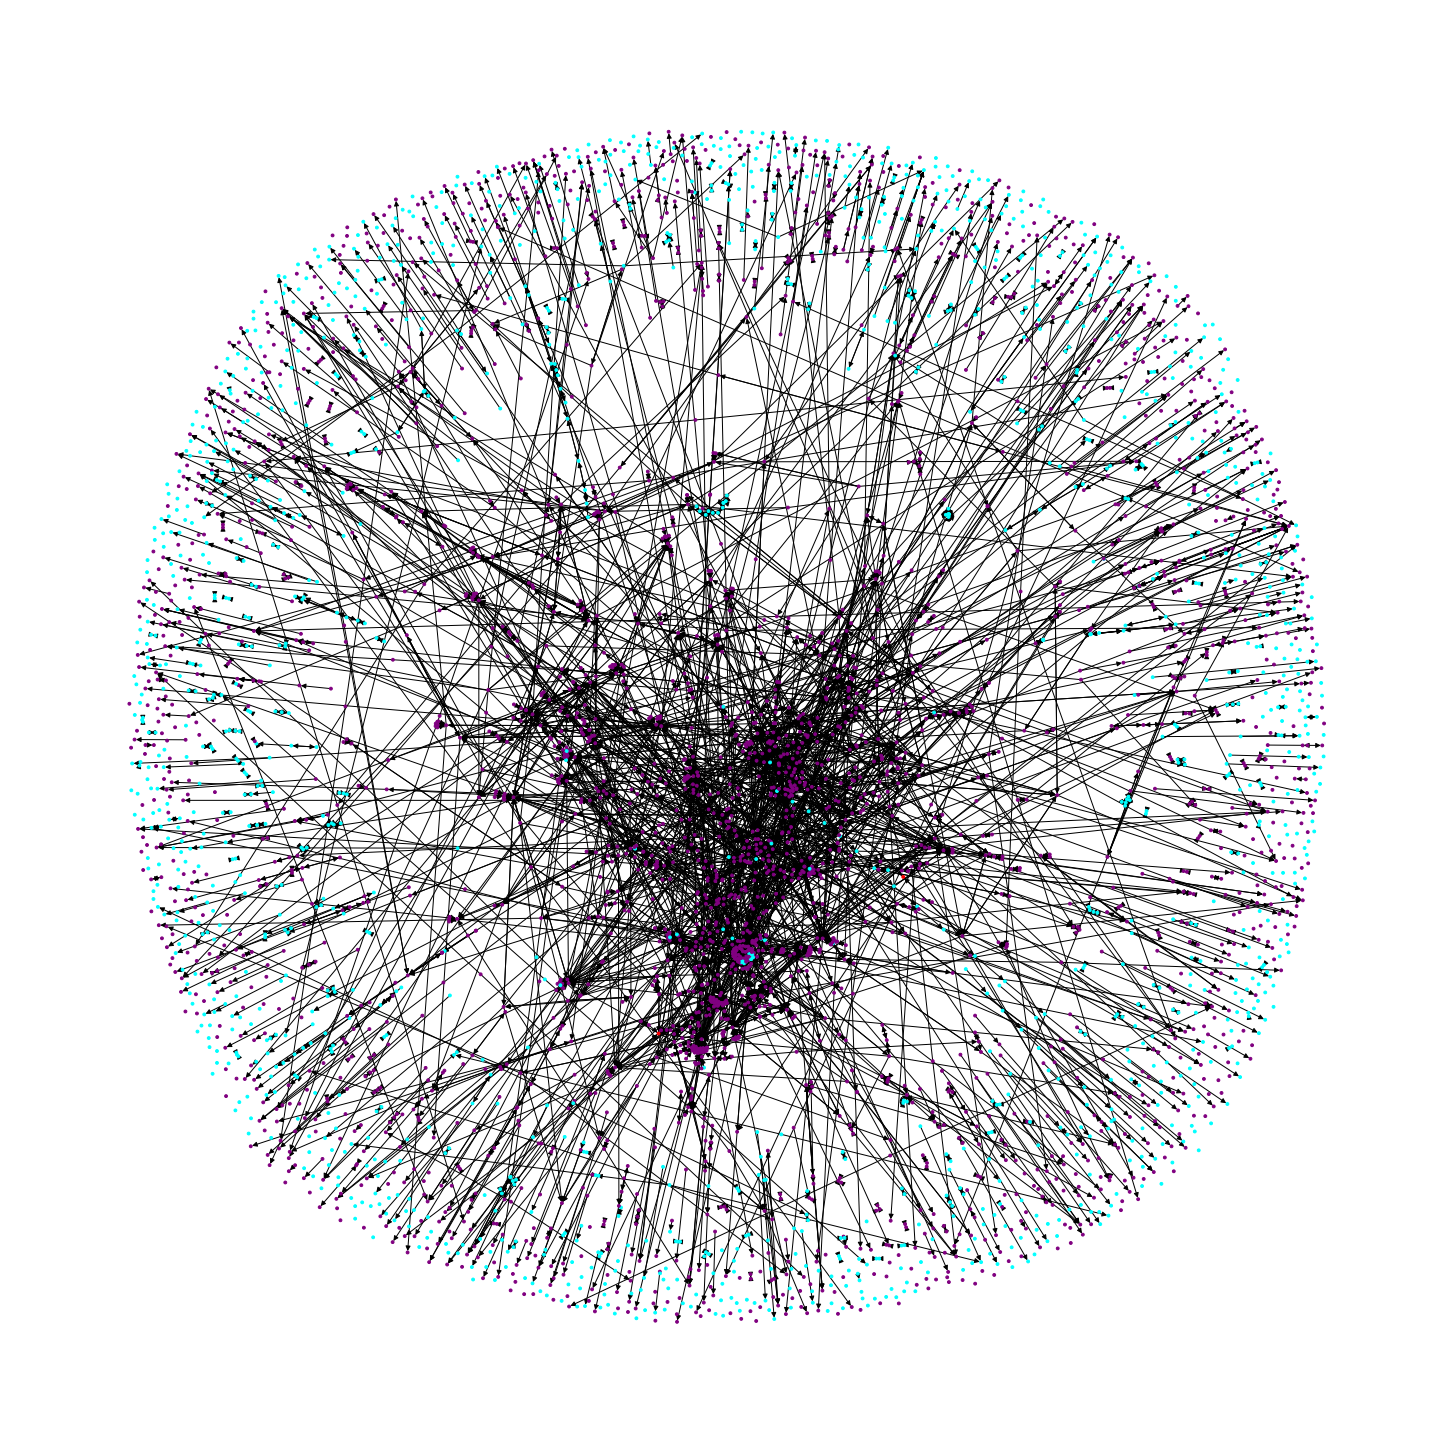

In [160]:
#map of links between the two categories
color_map = []
for node in H:
    
    if (node == u) or (node == v):
        color_map.append('red')
    elif node in final_category_dict[category1]:
        color_map.append('cyan')
    else: 
        color_map.append('purple')      
        
plt.figure(1, figsize = (20, 20))        
nx.draw(H, node_color=color_map, with_labels=False, node_size = 8)
plt.show()

### RQ5. Function 3

#### Write a function that, given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as $distance(C0, Ci) = median(ShortestPath(C0, Ci))$ 

#### Where $ShortestPath(C0, Ci)$ is the set of shortest paths from each pair of nodes in the two categories.

Since category are not in geleral completed connected the distance is computed bewteen each point of category C0 and each left categores wherever a connection occurs.

In [523]:
categories = list(final_category_dict.keys())
categories

['English_footballers',
 'The_Football_League_players',
 'Association_football_forwards',
 'Association_football_midfielders',
 'Association_football_defenders',
 'Harvard_University_alumni',
 'Major_League_Baseball_pitchers',
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies',
 'Indian_films',
 'Year_of_death_missing',
 'Rivers_of_Romania',
 'Main_Belt_asteroids',
 'Asteroids_named_for_people',
 'English-language_films',
 'American_films',
 'American_television_actors',
 'American_film_actors',
 'Debut_albums',
 'Black-and-white_films',
 'Year_of_birth_missing',
 'Place_of_birth_missing_(living_people)']

In [ ]:
C0 = input('choose a category: ')
categories.remove(C0)
# function returns the DataFrame of distances
data_distances = fn.category_distance(G, df, final_category_dict, C0, categories)

### RQ6. Function 4

#### Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm

---

Since we wanto to compute the pagerank between categories, we need to change the graph. First of all we need to understand in which category each node belongs.

In [40]:
G1 = nx.from_pandas_edgelist(df, "source", "target",create_using=nx.MultiDiGraph())

In [41]:
node_to_cat = fn.nodes_to_category(G1, final_category_dict)

100%|██████████| 98343/98343 [01:58<00:00, 832.75it/s] 
98343it [00:00, 1179185.99it/s]


We will rename each node in the graph with the name of the category it belongs to

In [44]:
G1 = nx.relabel_nodes(G1, node_to_cat)

In [45]:
G1['Debut_albums']

AdjacencyView({'Place_of_birth_missing_(living_people)': {0: {}}, 'English-language_films': {0: {}}, 'American_film_actors': {0: {}}, 'Debut_albums': {0: {}}, 'Harvard_University_alumni': {0: {}}, 'English_footballers': {0: {}}, 'American_television_actors': {0: {}}, 'American_films': {0: {}}, 'Black-and-white_films': {0: {}}, 'Major_League_Baseball_pitchers': {0: {}}, 'The_Football_League_players': {0: {}}, 'Year_of_birth_missing': {0: {}}, 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies': {0: {}}, 'Indian_films': {0: {}}, 'Year_of_death_missing': {0: {}}, 'Association_football_defenders': {0: {}}, 'Association_football_forwards': {0: {}}})

In [46]:
df3 = nx.to_pandas_edgelist(G1, source='source', target='target')
df3.head()

,source,target
0,Debut_albums,Place_of_birth_missing_(living_people)
1,Debut_albums,English-language_films
2,Debut_albums,American_film_actors
3,Debut_albums,Debut_albums
4,Debut_albums,Harvard_University_alumni


In [47]:
len(df3)

343

As we can see, we lost a lot of information in the graph, we started by having `483094` edges, and after this operation we have only `346`.

Now we need to calculate the probability that, if we are in a certain node, we will follow one of the many outgoing links of that node. In order to avoid too much loss of information, we will assign this probability proportionally to the number of edges that link together pair of categories. In this way if node A has 3 links to lead to node B, C and D;the probability of following each link will node be just 1/3 each but it will be the number of links that in the original graph link together pages of category A and B divided by the sum of those that link A and B, A and C, A and D. 

To do so, we first need to define a new dictionary that has for keys the categories, and for value all the other categories together with the number of links that in the original graph linked together the key category with all the others

In [56]:
dict_edge_cat = fn.count_edges_per_category(G,inverted_link2)

98343it [00:01, 87742.23it/s]


This dicitonary will be used to create a dataframe

In [49]:
df4 = pd.DataFrame.from_dict(dict_edge_cat)
df4 = df4.fillna(0)
df4.head()

,Debut_albums,Place_of_birth_missing_(living_people),English-language_films,American_film_actors,Members_of_the_United_Kingdom_Parliament_for_English_constituencies,American_films,American_television_actors,Harvard_University_alumni,English_footballers,Main_Belt_asteroids,...,Black-and-white_films,Association_football_midfielders,Association_football_forwards,Year_of_birth_missing,Association_football_defenders,The_Football_League_players,Major_League_Baseball_pitchers,Asteroids_named_for_people,Indian_films,Rivers_of_Romania
Place_of_birth_missing_(living_people),574.0,713.0,1744.0,268.0,39.0,644.0,196.0,131.0,14.0,4.0,...,62.0,11.0,12.0,47.0,11.0,24.0,6.0,1.0,415.0,0.0
English-language_films,570.0,1812.0,10605.0,34836.0,98.0,4865.0,23242.0,688.0,24.0,1.0,...,1289.0,2.0,9.0,178.0,1.0,38.0,49.0,2.0,239.0,0.0
American_film_actors,1248.0,899.0,42607.0,24231.0,34.0,30319.0,14172.0,721.0,14.0,17.0,...,21522.0,4.0,4.0,127.0,5.0,25.0,74.0,8.0,144.0,0.0
Debut_albums,779.0,229.0,103.0,288.0,4.0,29.0,154.0,22.0,4.0,0.0,...,6.0,1.0,1.0,6.0,6.0,3.0,2.0,1.0,3.0,0.0
Harvard_University_alumni,167.0,205.0,1168.0,663.0,140.0,642.0,430.0,3900.0,1.0,34.0,...,202.0,2.0,0.0,69.0,1.0,2.0,23.0,14.0,20.0,0.0


From it we will calculate the sum of each row and store it in a column at the end, this will be useful for the computation of the probabilities of following each link

In [50]:
column_list = list(df4)
df4["sum"] = df4[column_list].sum(axis=1)
df4

,Debut_albums,Place_of_birth_missing_(living_people),English-language_films,American_film_actors,Members_of_the_United_Kingdom_Parliament_for_English_constituencies,American_films,American_television_actors,Harvard_University_alumni,English_footballers,Main_Belt_asteroids,...,Association_football_midfielders,Association_football_forwards,Year_of_birth_missing,Association_football_defenders,The_Football_League_players,Major_League_Baseball_pitchers,Asteroids_named_for_people,Indian_films,Rivers_of_Romania,sum
Place_of_birth_missing_(living_people),574.0,713.0,1744.0,268.0,39.0,644.0,196.0,131.0,14.0,4.0,...,11.0,12.0,47.0,11.0,24.0,6.0,1.0,415.0,0.0,4930.0
English-language_films,570.0,1812.0,10605.0,34836.0,98.0,4865.0,23242.0,688.0,24.0,1.0,...,2.0,9.0,178.0,1.0,38.0,49.0,2.0,239.0,0.0,78647.0
American_film_actors,1248.0,899.0,42607.0,24231.0,34.0,30319.0,14172.0,721.0,14.0,17.0,...,4.0,4.0,127.0,5.0,25.0,74.0,8.0,144.0,0.0,136238.0
Debut_albums,779.0,229.0,103.0,288.0,4.0,29.0,154.0,22.0,4.0,0.0,...,1.0,1.0,6.0,6.0,3.0,2.0,1.0,3.0,0.0,1641.0
Harvard_University_alumni,167.0,205.0,1168.0,663.0,140.0,642.0,430.0,3900.0,1.0,34.0,...,2.0,0.0,69.0,1.0,2.0,23.0,14.0,20.0,0.0,7754.0
English_footballers,4.0,12.0,116.0,7.0,22.0,28.0,4.0,0.0,5749.0,0.0,...,879.0,1061.0,20.0,793.0,4730.0,1.0,0.0,0.0,0.0,13529.0
American_television_actors,547.0,559.0,26006.0,11731.0,13.0,13798.0,10222.0,312.0,10.0,8.0,...,1.0,2.0,44.0,2.0,12.0,40.0,5.0,149.0,0.0,66646.0
American_films,158.0,702.0,3927.0,23030.0,8.0,2871.0,11581.0,327.0,3.0,1.0,...,1.0,2.0,64.0,1.0,14.0,15.0,0.0,78.0,1.0,44007.0
Black-and-white_films,30.0,53.0,1432.0,14149.0,12.0,1296.0,2058.0,100.0,4.0,1.0,...,1.0,1.0,87.0,0.0,0.0,5.0,0.0,63.0,0.0,21477.0
Major_League_Baseball_pitchers,19.0,17.0,106.0,51.0,0.0,42.0,30.0,21.0,0.0,0.0,...,1.0,1.0,11.0,0.0,0.0,10460.0,0.0,0.0,0.0,10791.0


In [ ]:
M = fn.get_transition_matrix(df4, G1)   #transiotion matrix
nodes = [node for node in G1.nodes()]   #list of all categories which correspond to the nodes in the new graph

Now we have all we need to apply our pagerank algorithm:

In [53]:
fn.pagerank(100, 0.15, nodes, M, G1)

['American_film_actors',
 'English-language_films',
 'Debut_albums',
 'American_television_actors',
 'American_films',
 'The_Football_League_players',
 'English_footballers',
 'Rivers_of_Romania',
 'Indian_films',
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies',
 'Major_League_Baseball_pitchers',
 'Association_football_forwards',
 'Main_Belt_asteroids',
 'Association_football_midfielders',
 'Black-and-white_films',
 'Place_of_birth_missing_(living_people)',
 'Harvard_University_alumni',
 'Association_football_defenders',
 'Year_of_birth_missing',
 'Year_of_death_missing',
 'Asteroids_named_for_people']

### Another approach

In the previous approach we have approximated the whole category as a node.Here again the first step is to create the transition matrix of all edges where each row and each column refers to a node. The values in the matrix correspons to the probability to go from one node to the other, given by the weight that we have already computed

Being the matrix sparse and too big to be computed all at once (since it requires too much memory) we splitted it in 49 sub matrix to compute successfully, each matrix with side of 1/7 of the original one.

This approach is a lot slower because each time the sub matrix of probability which the program is working with must be retrieved from all data.

In [54]:
n = int(len(G1.nodes())/7)
n

14049

In [40]:
#here the nodes in the dataframe without links are saved for further use

row_of_zeroes = []
nodes = [node for node in G1.nodes()]             ##list of nodes in our graph
#for each row = each node
for i,source in tqdm(enumerate(G1.nodes())):
    nodes_linked = [elem for elem in G1[source]]
    if nodes_linked == []:
        row_of_zeroes.append(i)
        

98343it [00:00, 314051.15it/s]


In [41]:
len(row_of_zeroes)

7423

In [ ]:
v = fn.pagerank2(100, 0.1, G1, row_of_zeroes)

In [ ]:
sorted_cat = fn.order_categories(v, nodes, final_category_dict)
sorted_cat